# Question 1 :  
Ces fonctions renvoient des matrices de vecteurs aléatoires concaténés (X) dont on précise le nombre d'observations, la moyenne et l'écart-type ; ainsi qu'un vecteur de "target" aléatoire y qui dépend de X : si X[0] suit la loi N1, alors y = 0, si X[0] suit la loi N2, alors y = -1, etc.

In [1]:
from tp_knn_source import *

X1, y1 = rand_bi_gauss(20, 20, sigmas1=[.9,.9], sigmas2=[.9,.9]) #valeurs par défaut des moyennes correspondent à l'énoncé
X2, y2 = rand_tri_gauss(50, 50, 50, sigma1=[.9,.9], sigma2=[.9,.9], sigma3=[.9,.9]) #valeurs par défaut des moyennes correspondent à l'énoncé
X3, y3 = rand_clown(50,50,1,5)
X4, y4 = rand_checkers(150,150)

print("5 premiers vecteurs de chaque X, 5 premières target de chaque y :")
print(X1[:5], y1[:5])
print(X2[:5], y2[:5])
print(X3[:5], y3[:5])
print(X4[:5], y4[:5])

5 premiers vecteurs de chaque X, 5 premières target de chaque y :
[[ 0.45535087 -0.00196182]
 [-0.69674093 -0.56270555]
 [-1.28569989 -1.80242117]
 [ 0.23093977  0.73017571]
 [ 0.77976737 -0.37000532]] [-1. -1. -1.  1.  1.]
[[ 1.64494619 -1.9301296 ]
 [-0.43282656  0.05432882]
 [ 1.25440429  1.81277397]
 [-0.57411822 -0.74001157]
 [-1.40565902 -1.21978292]] [3. 2. 1. 2. 2.]
[[ 0.04875323  0.70113973]
 [ 7.04082467 12.01000588]
 [ 2.45742019  1.13696346]
 [-7.9742541  -5.98273074]
 [-1.31916998 -0.39712607]] [ 1. -1. -1. -1. -1.]
[[-2.03098418 -1.25449921]
 [ 1.14568332  0.33645125]
 [-1.51508274 -0.97767458]
 [ 1.81054886 -1.47685937]
 [-1.03336775 -0.0398407 ]] [1. 2. 1. 3. 1.]


# Question 2 :

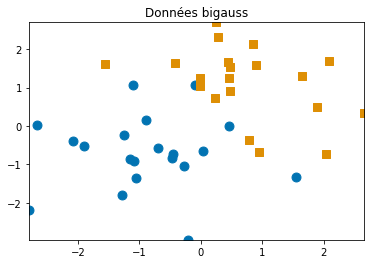

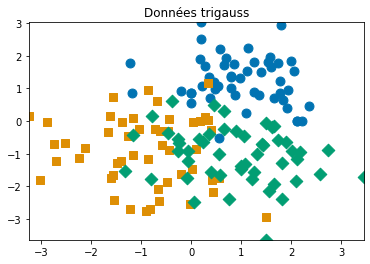

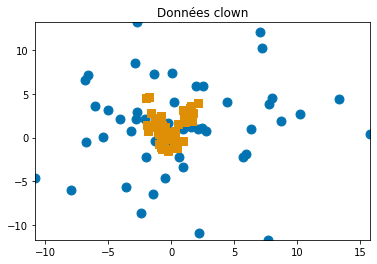

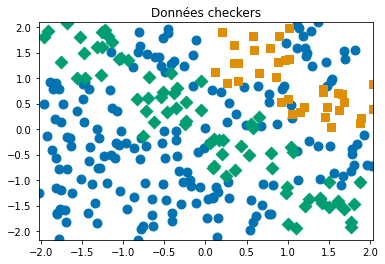

In [2]:
import matplotlib.pyplot as plt

names = ["bigauss","trigauss","clown","checkers"]
for i,(X,y) in enumerate([(X1,y1),(X2,y2),(X3,y3),(X4,y4)]):
    plot_2d(X,y)
    plt.title(f"Données {names[i]}")
    plt.show()

# Question 3 :
Pour une régression avec KNN, on peut considérer la moyenne de y pour les N observations les plus proches de l'observation considérée comme la prédiction du modèle.  
On peut en réalité considérer n'importe quelle agrégation (moyenne, médiane, max, min, ...), le choix dépend de l'indicateur qui répond le mieux aux attentes qu'on a vàv du modèle.

# Question 4 :

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial import distance

class KNNClassifier(BaseEstimator, ClassifierMixin):
    """ Homemade kNN classifier class """
    def __init__(self, n_neighbors=1):
        self.n_neighbors=n_neighbors
    def __call__(self, X): #Nécessaire pour utiliser la fonction frontiere_new du fichier source
        return self.predict(X)
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self
    def predict(self, X):
        distances = distance.cdist(self.X, X) #On pourrait ici implémenter différentes distances, par défaut on utiliser la distance euclidienne
        counts = [np.unique(self.y[np.argsort(dists)[:self.n_neighbors]], return_counts=True) for dists in distances.T]
        ypred = [value[np.argmax(count)] for value, count in counts]
        #[value[np.random.choice([i for i, x in enumerate(count) if x == max(count)])] for value, count in counts]
        #On utilise argmax car cette fonction renvoie des résultats similaires à sklearn
        #Il faut noter que argmax ne choisit pas vraiment arbitrairement : la première occurrence dans counts est renvoyée
        #Ce qui veut dire que la "première" classe est favorisée
        #La ligne commentée permettrait de corriger ce problème en choisissant arbitrairement parmi les classes en cas d'égalité
        return ypred

#Exemple de classification dans un cas d'égalité (on peut passer de la version argmax à la version random.choice pour comparer) :
knn = KNNClassifier(n_neighbors=4)
knn = knn.fit(np.array([[1,0],[0,1],[-1,0],[0,-1]]),np.array([1,1,-1,-1]))
print(knn(np.array([[0,0]])))

[-1]


In [4]:
from sklearn.neighbors import KNeighborsClassifier

#Avec X2 :

X_train, X_test, y_train, y_test = X2[np.array(range(len(X2)))%2==0], X2[~np.array(range(len(X2)))%2==0], \
                                   y2[np.array(range(len(X2)))%2==0], y2[~np.array(range(len(X2)))%2==0]

knn = KNNClassifier(n_neighbors=4)
knn = knn.fit(X_train,y_train)
ypred_ourknn = knn.predict(X_test)

sknn = KNeighborsClassifier(n_neighbors=4)
sknn = sknn.fit(X_train, y_train)
ypred_sklearn = sknn.predict(X_test)

print("Percentage of predictions in common between our implementation and sklearns' :")
print(np.all(ypred_ourknn == ypred_sklearn))

print("Our accuracy on test :")
print(knn.score(X_test, y_test))
print("Sklearn accuracy on test :")
print(sknn.score(X_test, y_test))
#Nous obtenons les mêmes résultats

Percentage of predictions in common between our implementation and sklearns' :
True
Our accuracy on test :
0.7733333333333333
Sklearn accuracy on test :
0.7733333333333333


# Question 5 :

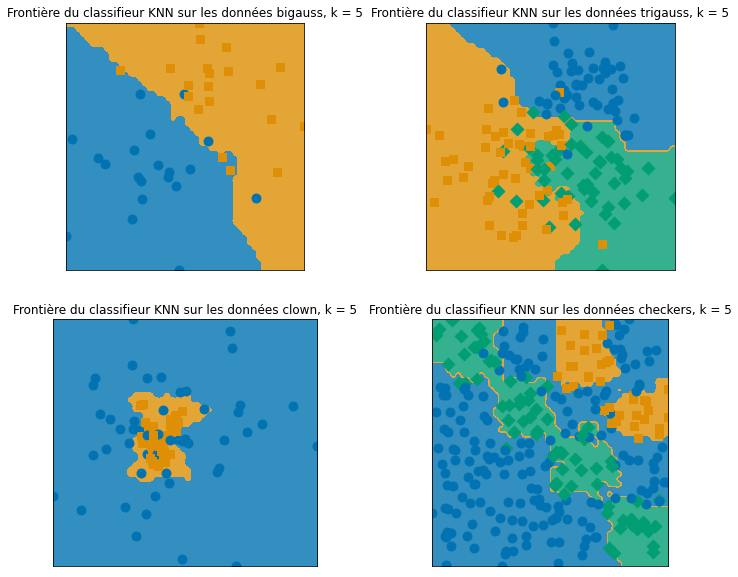

In [5]:
from functools import partial

def speshulpredict(Xnew, model, X):
    """special function to work with frontiere_new from source file"""
    if not isinstance(Xnew,np.ndarray): #si X n'est pas un objet numpy (liste par exemple)
        Xnew = np.array(Xnew)
    Xnew = Xnew.reshape(-1,X.shape[1])
    return model.predict(Xnew)

names = ["bigauss","trigauss","clown","checkers"]

fig = plt.figure(figsize=(12,10))

for i,(X,y) in enumerate([(X1,y1),(X2,y2),(X3,y3),(X4,y4)]):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn = knn.fit(X,y)
    fig.add_subplot(2,2,i+1)
    frontiere_new(partial(speshulpredict,model=knn,X=X), X, y, colorbar=False)
    plt.title(f"Frontière du classifieur KNN sur les données {names[i]}, k = 5")
plt.show()

# Question 6 :

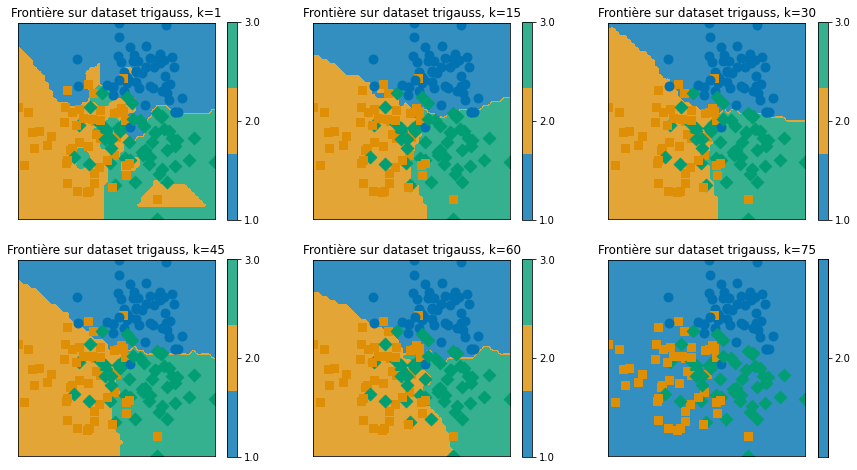

In [6]:
fig = plt.figure(figsize=(15,8))
n = len(X2)/2
X, y = X2[np.array(range(len(X2)))%2==0], y2[np.array(range(len(X2)))%2==0]
i=1
for k in np.linspace(1,n,6):
    knn = KNeighborsClassifier(n_neighbors=int(k))
    knn = knn.fit(X,y)
    fig.add_subplot(2,3,i)
    frontiere_new(partial(speshulpredict,model=knn,X=X2),X2,y2)
    plt.title(f"Frontière sur dataset trigauss, k={int(k)}")
    i+=1
plt.show()

A mesure que k tend vers 1, la frontière se complexifie. Forte variance, faible biais.  
A mesure que k tend vers n, la frontière se simplifie jusqu'à devenir le mode empirique de y sur les données d'entraînement. Variance nulle, fort biais.

# Question 7 :

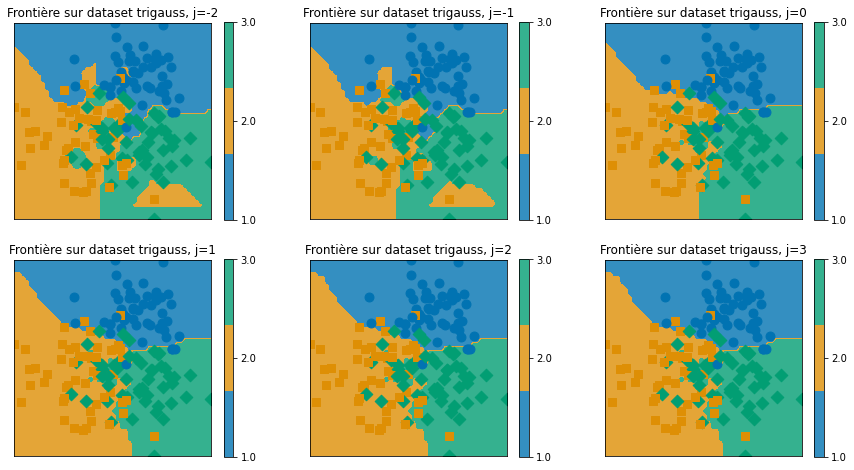

In [7]:
def _weight_func(dist,h): #D'après l'exemple donné dans l'énoncé
    with np.errstate(divide="ignore"):
        retval = np.exp(-(dist**2)/h)
    return retval

fig = plt.figure(figsize=(15,8))
i=1
for j in range(-2,4,1): #On a testé une valeur supplémentaire pour j afin d'obtenir un joli graphe symétrique
    knn = KNeighborsClassifier(7, weights=partial(_weight_func,h=10**j))
    knn = knn.fit(X,y) #On entraîne sur la moitié des données
    fig.add_subplot(2,3,i)
    frontiere_new(partial(speshulpredict,model=knn,X=X2),X2,y2)
    plt.title(f"Frontière sur dataset trigauss, j={j}")
    i+=1
plt.show()


# Question 8 :

In [8]:
X_train, X_test, y_train, y_test = X2[np.array(range(len(X2)))%2==0], X2[~np.array(range(len(X2)))%2==0], \
                                   y2[np.array(range(len(X2)))%2==0], y2[~np.array(range(len(X2)))%2==0]

knn = KNeighborsClassifier(1)
knn = knn.fit(X_train, y_train)
print("Taux d'erreur sur le train :")
print(1-knn.score(X_train, y_train))
print("Taux d'erreur sur le test :")
print(1-knn.score(X_test, y_test))
#Overfitting

Taux d'erreur sur le train :
0.0
Taux d'erreur sur le test :
0.3466666666666667


# Question 9 :

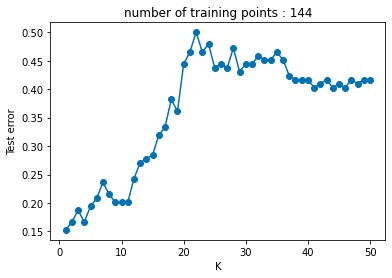

In [9]:
X_train, X_test, y_train, y_test = X4[np.array(range(len(X4)))%2==0], X4[~np.array(range(len(X4)))%2==0], \
                                   y4[np.array(range(len(X4)))%2==0], y4[~np.array(range(len(X4)))%2==0]

ec = ErrorCurve(range(1,51,1))
ec.fit_curve(X_train, y_train, X_test, y_test)
ec.plot()

# Question 10 :

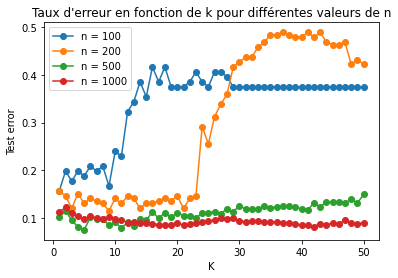

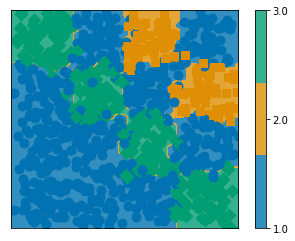

In [10]:
colors = sns.color_palette("tab10")[:4]

for i, n in enumerate([100,200,500,1000]):
    X_train, y_train = rand_checkers(n/2,n/2) #n/2 because rand_checkers generates n1+n2 points
    X_test, y_test = rand_checkers(n/2,n/2)
    ec = ErrorCurve(range(1,51,1))
    ec.fit_curve(X_train, y_train, X_test, y_test)
    ec.plot(maketitle=False, color=colors[i], label=f'n = {n}')
plt.legend()
plt.title("Taux d'erreur en fonction de k pour différentes valeurs de n")
plt.show()

knn = KNeighborsClassifier() #pas de précision dans l'énoncé, on utilise les valeurs par défaut, ie k = 5
knn = knn.fit(X_train, y_train) #X_train, y_train de la dernière itération de la boucle -> n = 1000
frontiere_new(partial(speshulpredict,model=knn,X=X_train), X_train, y_train)
plt.show()

La meilleure valeur empirique pour $k$ varie selon le dataset, donc selon le nombre de points d'entraînement.  
On retrouve que $k_{best}$ tend vers $+\infty$ à mesure que $n$ tend vers $+\infty$, plus lentement que $n$.

# Question 11 :  
Temps d'entraînement très rapide (nul), pas besoin d'algorithme d'optimisation type descente de gradient. C'est un avantage du modèle.  
Temps d'inférence pour une nouvelle observation dans le pire des cas $O(N)$ avec $N$ le nombre de points d'entraînement. Ce temps d'inférence dépend donc de $N$ ce qui n'est pas le cas pour beaucoup d'autres modèles (typiquement, les modèles linéaires). C'est un inconvénient du modèle.  
Aucune interprétabilité, la frontière est purement empirique : elle représente un indicateur de centralité (le mode dans la classification KNN, la moyenne dans la régression KNN) des données d'entraînement présentes dans des sous-espaces de l'espace de représentation des données. C'est un inconvénient du modèle.  
Le modèle ne fait aucune hypothèse sur les données, ou une hypothèse très faible : des moyennes locales permettent de généraliser à une représentation correcte des données dans l'espace. C'est un avantage du modèle : il a un faible biais, qu'on peut par ailleurs contrôler en jouant avec k.

# Question 12 :

(8, 8)


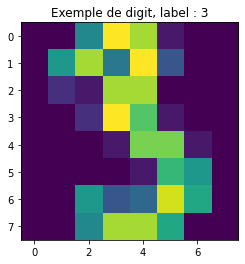

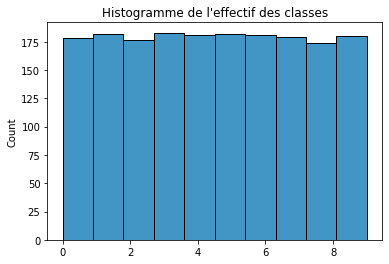

Les classes sont équilibrées (pas de surreprésentation significative d'une classe par rapport aux autres)
Shape des données d'entraînement :
(898, 64)
8x8=64
Taux d'erreur sur le test :
0.05339265850945496


In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns

digits = datasets.load_digits()
X, y = digits.images, digits.target

#Les données sont des images de chiffres manuscrits en 8 pixels par 8, la target correspond au chiffre, exemple :
np.random.randint(0,len(X)+1,1)
print(X[i].shape)
plt.imshow(X[i])
plt.title(f"Exemple de digit, label : {y[i]}")
plt.show()

sns.histplot(y,bins=10)
plt.title("Histogramme de l'effectif des classes")
plt.show()

print("Les classes sont équilibrées (pas de surreprésentation significative d'une classe par rapport aux autres)")

X_train, X_test, y_train, y_test = train_test_split(X.reshape(len(X),-1), y, test_size=0.5) #shuffle = True par défaut
#On reshape X pour obtenir les données sous forme de vecteurs

print("Shape des données d'entraînement :")
print(X_train.shape)
print("8x8=64") #quick maths

knn = KNeighborsClassifier(30)
knn = knn.fit(X_train, y_train)

print("Taux d'erreur sur le test :")
print(1-knn.score(X_test, y_test))

# Question 13 :

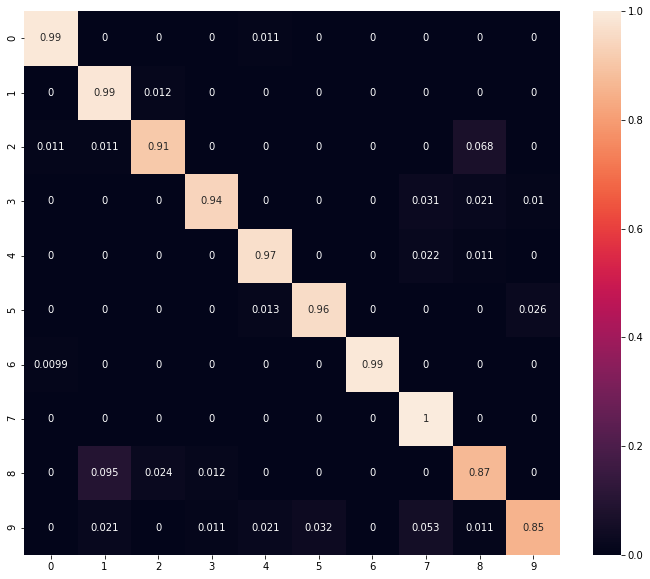

In [12]:
from sklearn.metrics import confusion_matrix

#on préfère sns.heatmap à plot_confusion_matrix de sklearn, mais en réalité les résultats sont strictement identiques 
#(on plot avec seaborn au lieu de laisser sklearn le faire)

plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix(y_test, knn.predict(X_test), normalize="true"), annot=True) 
#on utilise normalize = "true" pour éviter de surévaluer visuellement les classes les plus représentées
#même si en théorie, les classes sont équilibrées (effectifs par classe entre 86 et 92)
plt.show()

# Question 14 :

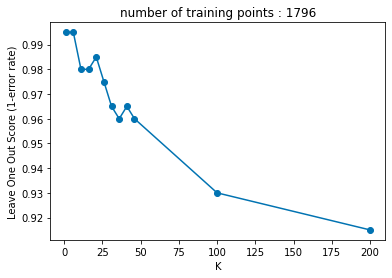

In [13]:
ec = LOOCurve(list(range(1,47,5))+[100,200])
ec.fit_curve(X.reshape(len(X),-1), y)
ec.plot()

# Question 15 :
On sait d'après le théorème de Bayes que :  
$$P(A|B) = P(A) \dfrac{P(B|A)}{P(B)}$$
Donc :  
$$P(Y=+1|X=x) = P(Y=+1) \dfrac{P(X=x|Y=+1)}{P(X=x)}\\
= \pi_+ \dfrac{f_+(x)}{f(x)} = \pi_+ \dfrac{f_+(x)}{f_+(x)+f_-(x)}
$$
et :
$$P(Y=-1|X=x) = P(Y=-1) \dfrac{P(X=x|Y=-1)}{P(X=x)}\\
= (1-\pi_+) \dfrac{f_-(x)}{f(x)} = (1-\pi_+) \dfrac{f_-(x)}{f_+(x)+f_-(x)}
$$

# Question 16 :  
$$\dfrac{P(Y=+1|X=x)}{P(Y=-1|X=x)} = \dfrac{\hat{\pi}_+ \dfrac{f_+(x)}{f(x)}}{(1-\hat{\pi}_+) \dfrac{f_-(x)}{f(x)}}\\
= \dfrac{\hat{\pi}_+}{(1-\hat{\pi}_+)} \cdot \dfrac{\exp\left(-\dfrac{1}{2}(x-\hat{\mu}_+)^T\hat{\Sigma}^{-1}(x-\hat{\mu}_+)\right)}{\exp\left(-\dfrac{1}{2}(x-\hat{\mu}_-)^T\hat{\Sigma}^{-1}(x-\hat{\mu}_-)\right)} \\
= \dfrac{\hat{\pi}_+}{(1-\hat{\pi}_+)} \cdot \exp\left(-\dfrac{1}{2}(x-\hat{\mu}_+)^T\hat{\Sigma}^{-1}(x-\hat{\mu}_+)+\dfrac{1}{2}(x-\hat{\mu}_-)^T\hat{\Sigma}^{-1}(x-\hat{\mu}_-)\right)$$
Donc : 
$$\log\left(\dfrac{P(Y=+1|X=x)}{P(Y=-1|X=x)}\right) = -\dfrac{1}{2}(x-\hat{\mu}_+)^T\hat{\Sigma}^{-1}(x-\hat{\mu}_+)+\dfrac{1}{2}(x-\hat{\mu}_-)^T\hat{\Sigma}^{-1}(x-\hat{\mu}_-)+\log(\hat{\pi}_+)-\log(1-\hat{\pi}_+)$$

# Question 17 :  
Par définition d'un classifieur, on a :
$$
g(x) = \begin{cases}+1 & \text{si } P(Y=+1|X=x)\geq P(Y=-1|X=x)\\ -1 & \text{sinon} \end{cases} \\
\iff \begin{cases}+1 & \text{si } \dfrac{P(Y=+1|X=x)}{P(Y=-1|X=x)} \geq 1 \\ -1 & \text{sinon} \end{cases} \\
\iff \begin{cases}+1 & \text{si } \log(\dfrac{P(Y=+1|X=x)}{P(Y=-1|X=x)}) \geq 0 \\ -1 & \text{sinon} \end{cases} \\
\iff \begin{cases}+1 & \text{si } -\dfrac{1}{2}(x-\hat{\mu}_+)^T\hat{\Sigma}^{-1}(x-\hat{\mu}_+)+\dfrac{1}{2}(x-\hat{\mu}_-)^T\hat{\Sigma}^{-1}(x-\hat{\mu}_-)+\log(\hat{\pi}_+)-\log(1-\hat{\pi}_+) \geq 0 \\ -1 & \text{sinon} \end{cases}
$$
En développant et en simplifiant, on obtient alors :
$$
\begin{cases}+1 & \text{si } x^T\hat{\Sigma}^{-1}(\hat{\mu}_+-\hat{\mu}_-) \geq \frac{1}{2}\hat{\mu}_+^T\hat{\Sigma}^{-1}\hat{\mu}_+-\frac{1}{2}\hat{\mu}_-^T\hat{\Sigma}^{-1}\hat{\mu}_--\log(\hat{\pi}_+)+\log(1-\hat{\pi}_+) \\ -1 & \text{sinon} \end{cases}
$$
Avec $\hat{\pi}_+ = m/n$, soit le classifieur proposé.

# Question 18 :

In [14]:
class LDAClassifier(BaseEstimator, ClassifierMixin):
    """ Homemade LDA class """
    def __init__(self):
        return None
    def fit(self, X, y):
        self.labels = sorted(np.unique(y))
        if len(self.labels) > 2:
            raise ValueError("Binary classification only")
        self.X = X
        self.y = y
        self.n = len(y)
        self.m = sum(y==self.labels[-1])
        self.p = self.m/self.n
        self.muplus = np.mean(X[y==self.labels[-1]],axis=0).reshape(-1,1)
        self.muminus = np.mean(X[y!=self.labels[-1]],axis=0).reshape(-1,1)
        self.sigmaplus = np.cov(X[y==self.labels[-1]].T)
        self.sigmaminus = np.cov(X[y!=self.labels[-1]].T)
        self.sigma = 1/(self.n-2)*((self.m-1)*self.sigmaplus+(self.n-self.m-1)*self.sigmaminus)
        #On calcule les estimateurs d'après les formules de l'énoncé
        return self
    def predict(self, X):
        inv_sigma = np.linalg.inv(self.sigma)
        values = X@inv_sigma@(self.muplus-self.muminus) #Premier terme de l'inégalité de l'énoncé
        threshold = .5*self.muplus.T@inv_sigma@self.muplus \
                    -.5*self.muminus.T@inv_sigma@self.muminus \
                    +np.log(1-self.p)-np.log(self.p) #Second terme
        ypred = values>=threshold
        return list(map({i:k for i,k in enumerate(self.labels)}.get,ypred.astype(int).flatten()))
        #Cette dernière ligne un peu compliquée permet d'être robuste à tous types de labels dans la target : strings, entiers positifs ou négatifs, etc.


# Question 19 :

Our model's error rate :
0.034545454545454546
Our confusion matrix :


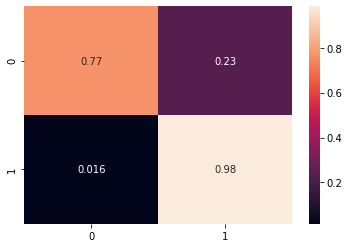

Our F1 score :
0.981169474727453

Sklearn model's error rate :
0.034545454545454546
Sklearn confusion matrix :


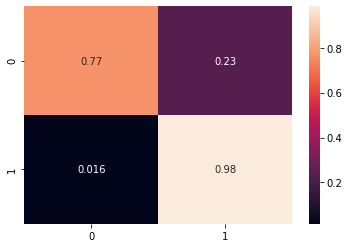

Sklearn F1 score :
0.981169474727453

Sklearn predictions and our predictions are the same : True


In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score

X, y = rand_bi_gauss(1000,100,sigmas1=[.9,.9],sigmas2=[.9,.9]) #classes déséquilibrées

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0) #On sépare en train et test comme depuis le début du TP, ie moitié-moitié

ourlda = LDAClassifier()
ourlda = ourlda.fit(X_train, y_train)
print("Our model's error rate :")
print(1-ourlda.score(X_test, y_test))
print("Our confusion matrix :")
sns.heatmap(confusion_matrix(y_test,ourlda.predict(X_test),normalize="true"),annot=True)
plt.show()
print("Our F1 score :")
print(f1_score(y_test, ourlda.predict(X_test)))

print()

sklda = LinearDiscriminantAnalysis(solver="eigen") #solver="eigen" -> équivalent à notre méthode (on n'a pas implémenté de SVD)
sklda = sklda.fit(X_train, y_train)
print("Sklearn model's error rate :")
print(1-sklda.score(X_test, y_test))
print("Sklearn confusion matrix :")
sns.heatmap(confusion_matrix(y_test,sklda.predict(X_test),normalize="true"),annot=True)
plt.show()
print("Sklearn F1 score :")
print(f1_score(y_test, sklda.predict(X_test)))

print()

print("Sklearn predictions and our predictions are the same :", np.all(sklda.predict(X_test) == ourlda.predict(X_test)))

# Question 20 :

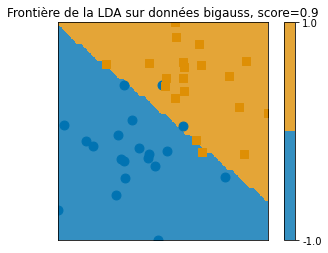

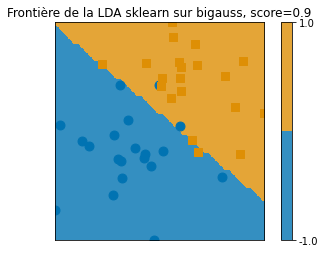

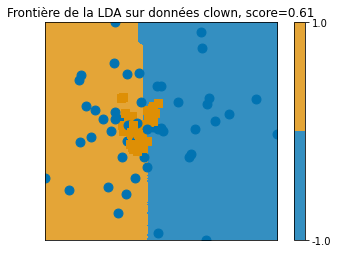

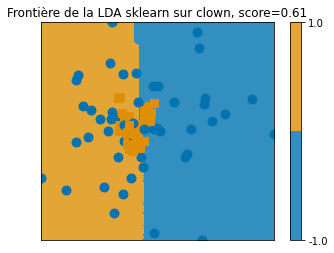

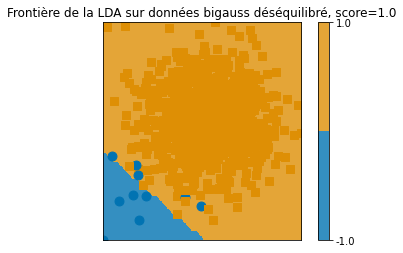

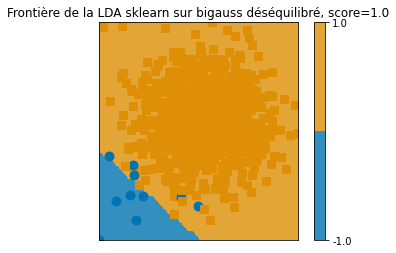

In [16]:
X5,y5 = rand_bi_gauss(1000,10,sigmas1=[.9,.9],sigmas2=[.9,.9]) #On utilise les sets 1 et 3, plus un set déséquilibré

lda = LDAClassifier()
sklda = LinearDiscriminantAnalysis(solver="eigen")
names = ["bigauss","clown","bigauss déséquilibré"]
for i, (X,y) in enumerate([(X1,y1),(X3,y3),(X5,y5)]):
    lda = lda.fit(X,y)
    frontiere_new(partial(speshulpredict,model=lda,X=X),X,y)#,colorbar=False)
    plt.title(f"Frontière de la LDA sur données {names[i]}, score={round(lda.score(X,y),2)}")
    plt.show()
    sklda = sklda.fit(X,y)
    frontiere_new(partial(speshulpredict,model=sklda,X=X),X,y)#,colorbar=False)
    plt.title(f"Frontière de la LDA sklearn sur {names[i]}, score={round(sklda.score(X,y),2)}")
    plt.show()

# Question 21 :

In [17]:
from sklearn.linear_model import LogisticRegression

X, y = rand_bi_gauss(1000,100,sigmas1=[.9,.9], sigmas2=[.9,.9])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

clf = LogisticRegression()
clf = clf.fit(X_train,y_train)
print("Taux d'erreur de la régression logistique :")
print(1 - clf.score(X_test,y_test))

print()

lda = LDAClassifier()
lda = lda.fit(X_train, y_train)
print("Taux d'erreur de la LDA :")
print(1 - lda.score(X_test, y_test))

Taux d'erreur de la régression logistique :
0.0

Taux d'erreur de la LDA :
0.004545454545454519


# Question 22 :  
La régression logistique a pour équation :  
$$log(\frac{P}{1-P}) = \beta_0 + \beta_1X$$
soit :
$$P = \frac{1}{1+e^{-(\beta_0 + \beta_1X)}}$$
L'attribut `coef_` correspond aux coefficients $\beta_1$, l'attribut `intercept_` correspond à $\beta_0$.

# Question 23 :

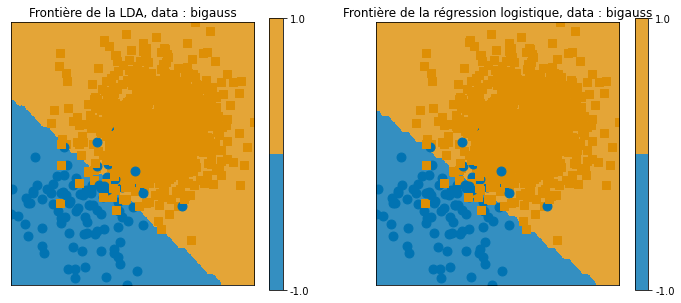

In [18]:
fig = plt.figure(figsize=(12,5))
fig.add_subplot(1,2,1)
frontiere_new(partial(speshulpredict,model=lda,X=X),X,y)
plt.title(f"Frontière de la LDA, data : bigauss")
fig.add_subplot(1,2,2)
frontiere_new(partial(speshulpredict,model=clf,X=X),X,y)
plt.title(f"Frontière de la régression logistique, data : bigauss")
plt.show()

# Question 24 :

In [19]:
from IPython.display import clear_output

digits = datasets.load_digits()
X, y = digits.images, digits.target

X_train, X_test, y_train, y_test = train_test_split(X.reshape(len(X),-1), y, test_size=0.5) #shuffle = True par défaut
#On reshape X pour obtenir les données sous forme de vecteurs

clf = LogisticRegression()
clf = clf.fit(X_train,y_train)
clear_output(wait=True) 
print("Taux d'erreur de la régression logistique sur l'échantillon de test :")
print(1-clf.score(X_test,y_test))

Taux d'erreur de la régression logistique sur l'échantillon de test :
0.03448275862068961
